# Lecture 4. CUDA streams.

In this lecture we will talk about CUDA streams.

A CUDA stream represents a queue of operations to be run on GPU. The operations enqueued in the stream are executed in issue-order.

CUDA allows to execute multiple streams concurrently. 

When no stream is specified, a default (null) stream is used. The properties of null stream and custom stream may impact the execution time of your code, so it's worth to dive into details of each type of stream. 

We will describe CUDA streams in more detail in the following subsections.

You can also find great slides about CUDA streams [here](https://developer.download.nvidia.com/CUDA/training/StreamsAndConcurrencyWebinar.pdf).

As previously, install `gpu_short_course` Python package first. 

In [1]:
! pip install --upgrade --force-reinstall git+https://github.com/pjarosik/ius-2021-gpu-short-course.git

  Cloning https://github.com/pjarosik/ius-2021-gpu-short-course.git to /tmp/pip-req-build-rldwkh55
  Running command git clone -q https://github.com/pjarosik/ius-2021-gpu-short-course.git /tmp/pip-req-build-rldwkh55
  Created wheel for gpu-short-course: filename=gpu_short_course-0.0.1-py3-none-any.whl size=5434 sha256=5887fe1be9ab2bfd047f63bbfc57e4c74a0e63e10f41b94bd15a7ca7f44d2f59
  Stored in directory: /tmp/pip-ephem-wheel-cache-w8z_a0l7/wheels/4f/07/fc/9537d8ac1b84ce9cde4db4fcebd10fd77e93ea2c18fcb8a656
Successfully built gpu-short-course
  Attempting uninstall: gpu-short-course
    Found existing installation: gpu-short-course 0.0.1
    Uninstalling gpu-short-course-0.0.1:
      Successfully uninstalled gpu-short-course-0.0.1


The `gpu_short_course` package includes CUDA kernels for ultrasound signal processing and ultrasound image reconstruction. For the purpose of this notebook, our processing pipeline will consists of three steps:
- ultrasound beamforming (in time-domain),
- Hilbert transform for envelope detection,
- a conversion to B-mode image, i.e. log compression and dynamic range adjustment.

The image reconstruction is done based on raw ultrasound channel data. You can find the example data in `exercises/data` subdirectory.

In Numba, you can specify a stream as a third CUDA kernel invocation parameter:
```
my_gpu_kernel[grid, block, stream]()
```

When no stream is provided, a default stream will be used. The default stream will be also used for `stream = 0`.  

For more details, you can check [ultrasound_imaging.py](https://github.com/us4useu/ius-2021-gpu-short-course/blob/main/gpu_short_course/ultrasound_imaging.py#L117) source code.

In [2]:
import numpy as np
import cupy as cp
from numba import cuda
from gpu_short_course.ultrasound_imaging import (
    # Utility functions.
    read_data,
    init_beamformer,
    create_grid,
    display_bmode,
    # GPU kernels.
    beamform,
    hilbert,
    to_bmode
)

GPU:0: b'GeForce MX250'


In [3]:
# Uncomment the below when running the notebook on Google Colab.
# ! rm pwi_cyst_simulated.pkl
# ! mkdir data 
# ! wget https://github.com/us4useu/ius-2021-gpu-short-course/raw/main/exercises/data/pwi_cyst_simulated.pkl
# ! mv pwi_cyst_simulated data
rf, context = read_data("data/pwi_cyst_simulated.pkl")

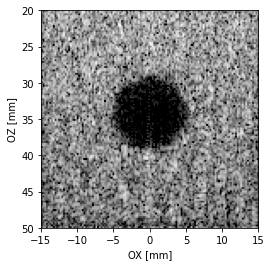

In [4]:
# Do some basic intitialization: move some constant
# data to GPU memory, do some pre-calculations, etc.
context = init_beamformer(rf, context)

# Create streams
stream = cp.cuda.Stream.null

# Do the processing on GPU:
hri        = beamform(rf, context, stream=stream)
envelope   = hilbert(hri, context, stream=stream)
bmode      = to_bmode(envelope, stream=stream).get() 
# .get() is a CuPy function that copies data from GPU to host PC.

display_bmode(bmode.T)

The above result shows an ultrasound image (a *B-mode image*) for a single cyst, simulated using [Field II software](https://field-ii.dk/).

## Exercise 4.1. Deafult stream.

Default stream (also called `null` stream):
- which is used when no stream is explicitly specified,
- is (mostly) synchronous w.r.t. to host and device.

Let's use default stream explicitly and gather and visualize some profiling data using NVIDIA profiler (see Lecture 1. for more information):

In [5]:
%%writefile 4_1_default_stream.py
import numpy as np
import cupy as cp
from numba import cuda
from gpu_short_course.ultrasound_imaging import (
    # utility functions
    read_data,
    init_beamformer,
    create_grid,
    display_bmode,
    # GPU functions
    beamform,
    hilbert,
    to_bmode
)
rf, context = read_data("data/pwi_cyst_simulated.pkl")
context = init_beamformer(rf, context)

# Create streams
stream = cp.cuda.Stream.null

# Do the processing 10 times:

for i in range(10): 
    rf_gpu     = cuda.to_device(rf)
    hri        = beamform(rf_gpu, context, stream=stream)
    envelope   = hilbert(hri, context, stream=stream)
    bmode      = to_bmode(envelope, stream=stream)
    bmode_host = bmode.get(stream=stream)

Overwriting 4_1_default_stream.py


In [6]:
! nvprof --trace gpu python 4_1_null_stream.py

==64550== NVPROF is profiling process 64550, command: python 4_1_null_stream.py
GPU:0: b'GeForce MX250'
==64550== Profiling application: python 4_1_null_stream.py
==64550== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   66.12%  150.27ms        10  15.027ms  14.264ms  15.746ms  cudapy::gpu_short_course::ultrasound_imaging::reconstruct$241(Array<float, int=2, C, mutable, aligned>, Array<float, int=3, C, mutable, aligned>, Array<double, int=1, C, mutable, aligned>, Array<double, int=1, C, mutable, aligned>, Array<float, int=1, C, mutable, aligned>, Array<double, int=1, C, mutable, aligned>, float, float)
                   33.57%  76.292ms        14  5.4494ms     864ns  7.6566ms  [CUDA memcpy HtoD]
                    0.09%  214.40us        10  21.440us  20.032us  26.656us  [CUDA memcpy DtoH]
                    0.05%  104.10us        10  10.409us  9.9200us  11.040us  cupy_max
                    0.04%  100.39us      

In [7]:
! nvprof --trace gpu --export-profile 4_1_default_stream.nvvp -f python 4_1_default_stream.py

==64577== NVPROF is profiling process 64577, command: python 4_1_default_stream.py
GPU:0: b'GeForce MX250'
==64577== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/4_1_default_stream.nvvp


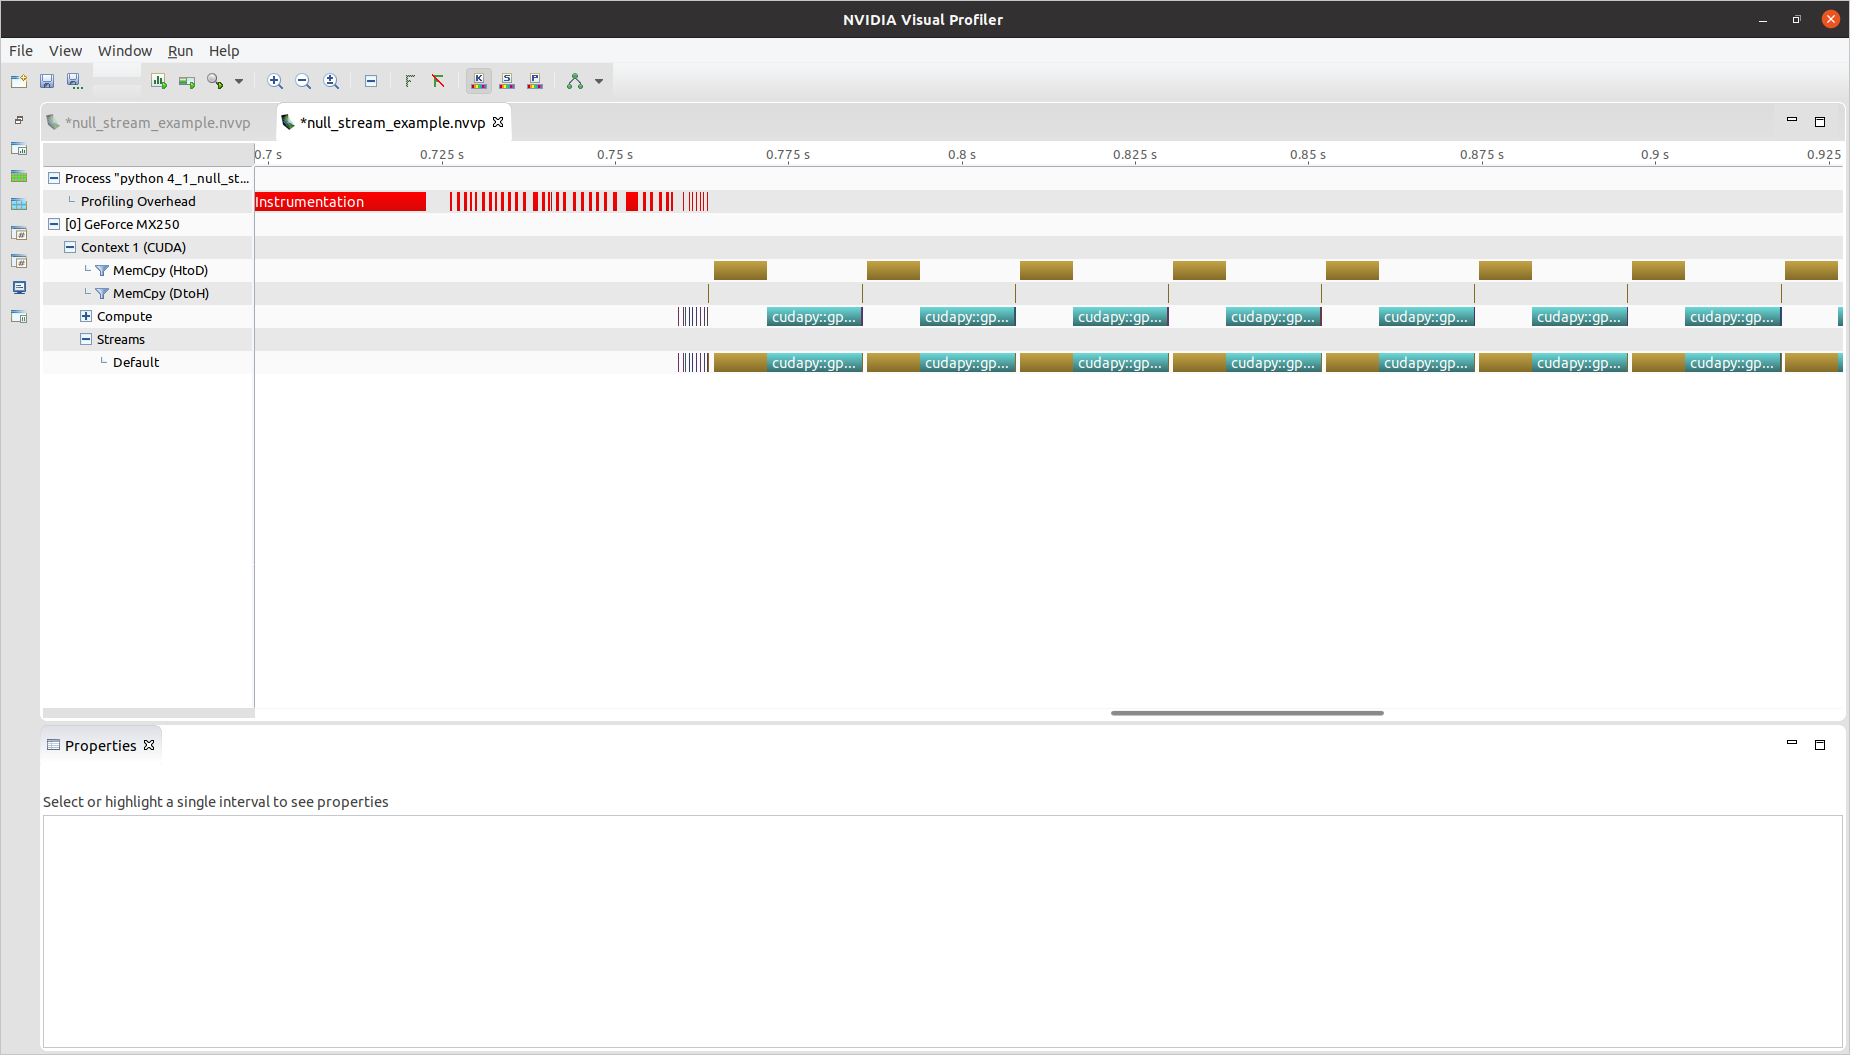

In the image above, we can see the moments of executing the kernels. The kernels were executed one after the other in the order in which they were issued in the Python script, as can be seen in `Streams -> Default` lane. Notice that the stream execution also includes Host to Device (HtoD) and Device to Host (DtoH) transfers (*orange* boxes). 

When using Numba, we must remember that when we invoke a Numba kernel the first time, kernel's source code is compiled from Python to the GPU machine code. Subsequent calls invokes previously compiled (and cached) code. Therefore some sparsity in first call invocation can be seen in the profiler, just like the in picture below.

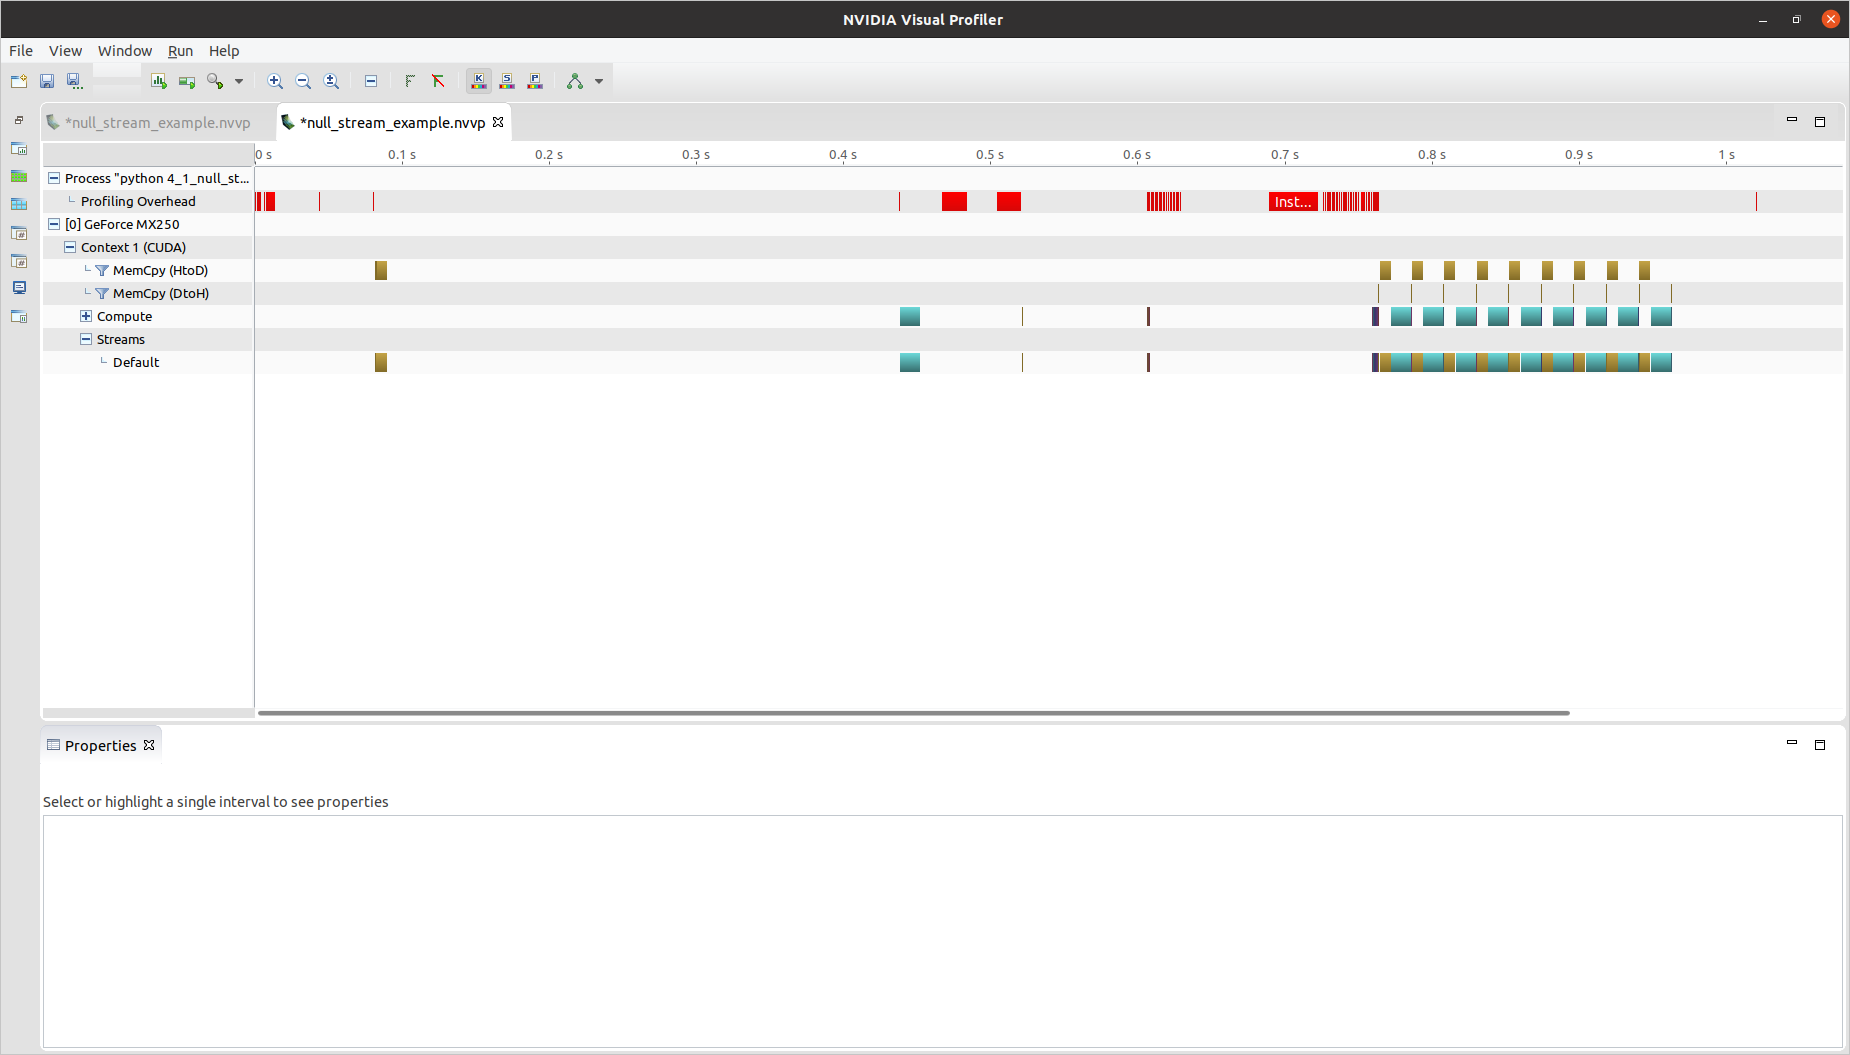

When using one stream (e.g. the default stream), the kernels are executed one after the other, in the issue-order. Within a single stream, kernels cannot run in parallel, even if their results are independent of each other. The script below demonstrates the situation where we are running two independent processes (i.e. image reconstruction and adding two arbitrary vectors) within one default stream.

As you can see in the image below, the `add_vectors` kernel has been executed between `beamform` and `hilbert` transform kernels.

In [8]:
%%writefile 4_1_default_stream_blocking_example.py
import numpy as np
import cupy as cp
from numba import cuda
import math
from gpu_short_course.ultrasound_imaging import (
    # utility functions
    read_data,
    init_beamformer,
    create_grid,
    display_bmode,
    # GPU functions
    beamform,
    hilbert,
    to_bmode
)
rf, context = read_data("data/pwi_cyst_simulated.pkl")
context = init_beamformer(rf, context)

# ADDING VECTORS in CUDA -- see e.g. Lecture 1.
a = np.random.rand(2**24).astype(np.float32)
a = cuda.to_device(a)
b = np.random.rand(2**24).astype(np.float32)
b = cuda.to_device(b)

result = cuda.device_array(a.shape, dtype=np.float32)

@cuda.jit
def add_vectors(result, a, b):
    i = cuda.grid(1)
    if i >= len(a):
        return
    result[i] = a[i] + b[i]

# Create streams
stream = cp.cuda.Stream.null

# Do the processing 10 times:
for i in range(10): 
    rf_gpu     = cuda.to_device(rf)
    hri        = beamform(rf_gpu, context, stream=stream)
    envelope   = hilbert(hri, context, stream=stream)

    # Now do some unrelated job.
    # 0 means null stream
    add_vectors[math.ceil(len(result)/256), 256, 0](result, a, b)

    # Do the rest of the job.
    bmode      = to_bmode(envelope, stream=stream)
    bmode_host = bmode.get(stream=stream)

Overwriting 4_1_default_stream_blocking_example.py


In [9]:
! nvprof --trace gpu --export-profile 4_1_default_stream_blocking_example.nvvp -f python 4_1_default_stream_blocking_example.py

==64604== NVPROF is profiling process 64604, command: python 4_1_default_stream_blocking_example.py
GPU:0: b'GeForce MX250'
==64604== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/4_1_default_stream_blocking_example.nvvp


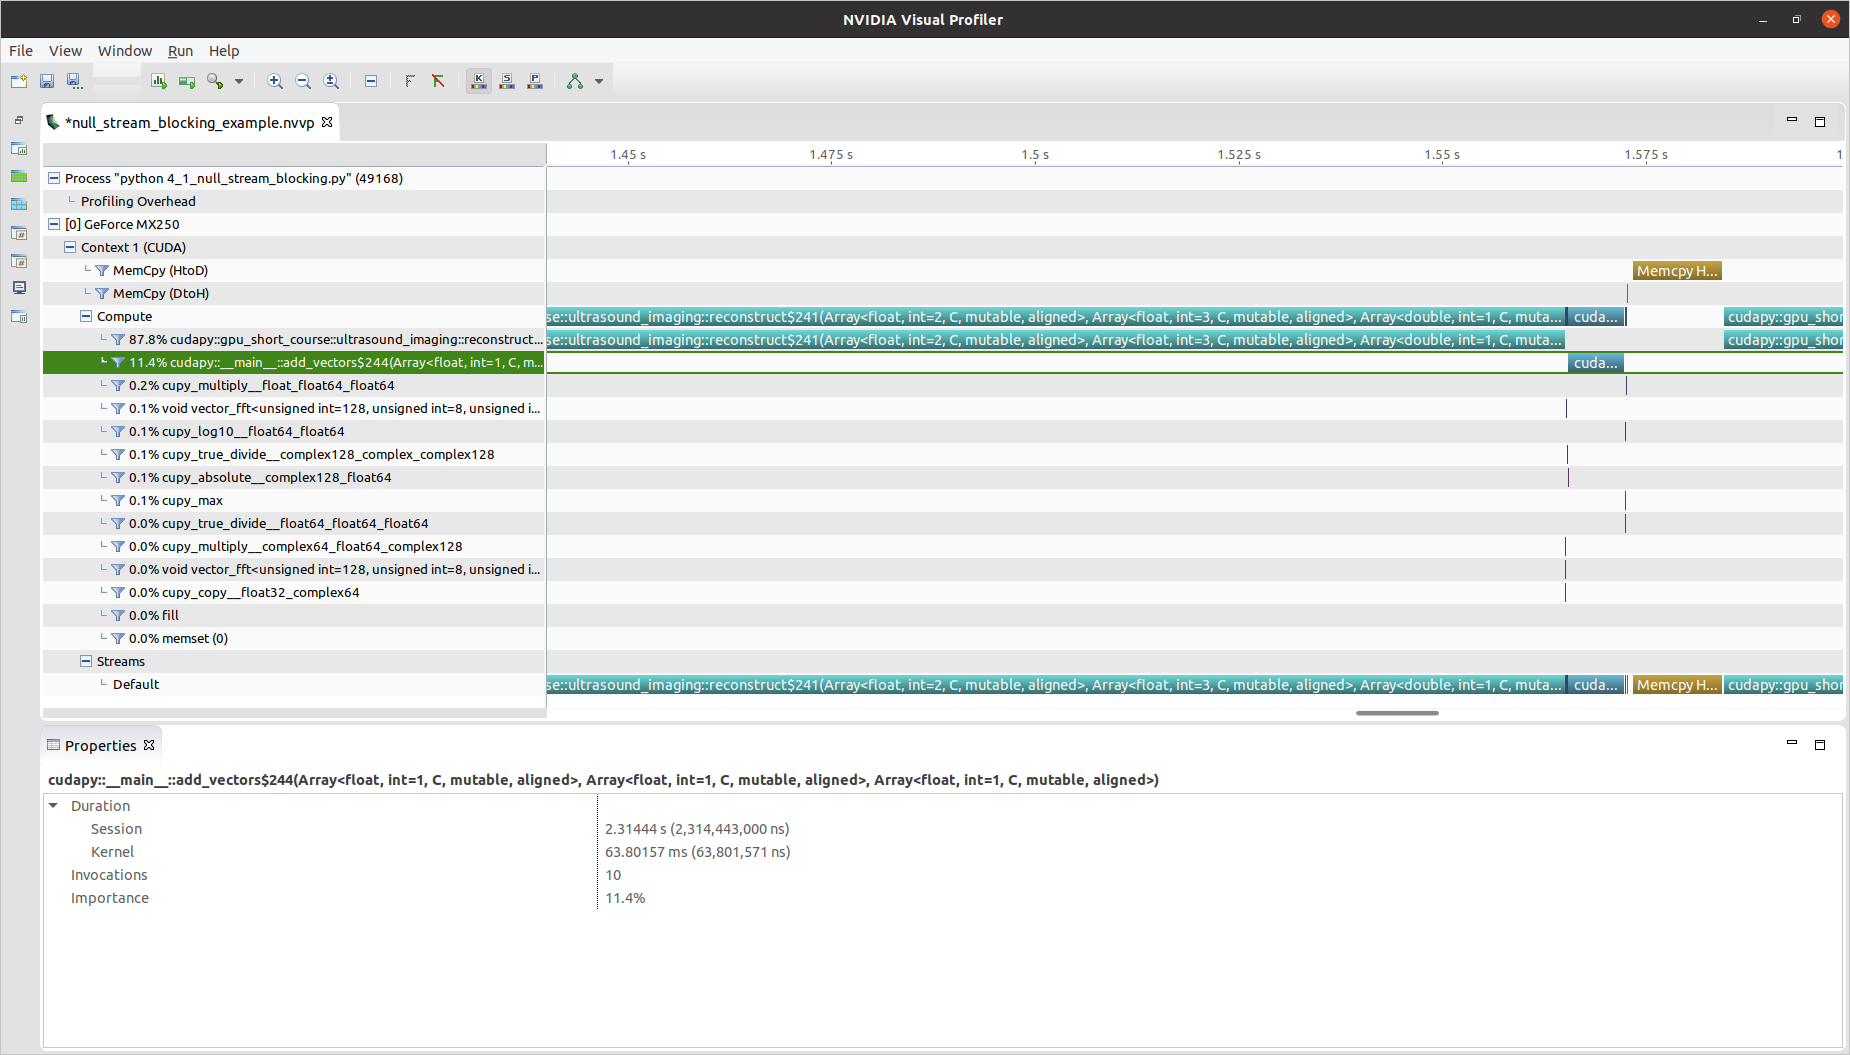



## Exercise 4.2. Custom streams.

If you want to run some kernels in parallel, you need to create a custom CUDA stream.

CUDA programming toolkit provides means to to create a custom stream with a specific parameters. 

In Numba, you can use [`numba.cuda.stream()`](https://numba.pydata.org/numba-doc/latest/cuda-reference/host.html#numba.cuda.stream) to create a custom stream.

In CuPy, you can create an instance of [`cupy.cuda.Stream`](https://docs.cupy.dev/en/stable/reference/generated/cupy.cuda.Stream.html).

For the rest of this notebook we will use CuPy in order to manage CUDA streams in our scripts.

### Exercise 4.2.1. Overlapping streams.

The below example creates two concurrent streams for the vector addition and ultrasound imaging.

In [10]:
%%writefile 4_2_1_parallel_streams.py
import numpy as np
import cupy as cp
from numba import cuda
import math
from gpu_short_course.ultrasound_imaging import (
    # utility functions
    read_data,
    init_beamformer,
    create_grid,
    display_bmode,
    # GPU functions
    beamform,
    hilbert,
    to_bmode
)
rf, context = read_data("data/pwi_cyst_simulated.pkl")
context = init_beamformer(rf, context)

# ADDING VECTORS in CUDA -- see e.g. Lecture 1.
a = np.random.rand(2**24).astype(np.float32)
a = cuda.to_device(a)
b = np.random.rand(2**24).astype(np.float32)
b = cuda.to_device(b)

result = cuda.device_array(a.shape, dtype=np.float32)

@cuda.jit
def add_vectors(result, a, b):
    i = cuda.grid(1)
    if i >= len(a):
        return
    result[i] = a[i] + b[i]

# Create streams
ultrasound_imaging_stream = cp.cuda.Stream(non_blocking=True)
add_vectors_stream = cp.cuda.Stream(non_blocking=True)
# Make the above stream available from Numba package.
add_vectors_stream_numba = cuda.external_stream(add_vectors_stream.ptr)

rf_gpu = cp.zeros(rf.shape, dtype=cp.float32)
for i in range(10): 
    rf_gpu.set(rf, stream=ultrasound_imaging_stream)
    hri        = beamform(rf_gpu, context, stream=ultrasound_imaging_stream)
    envelope   = hilbert(hri, context, stream=ultrasound_imaging_stream)

    # Now do some unrelated job (in a separate stream).
    add_vectors[math.ceil(len(result)/256), 256, add_vectors_stream_numba](result, a, b)

    # Do the rest of the job.
    bmode      = to_bmode(envelope, stream=ultrasound_imaging_stream)
    bmode_host = bmode.get(stream=ultrasound_imaging_stream)

# Wait untill all tasks in the ultrasound_imaging_stream and add_vectors_stream are completed.
ultrasound_imaging_stream.synchronize()
add_vectors_stream_numba.synchronize()

Overwriting 4_2_parallel_streams.py


In [11]:
! nvprof --trace gpu --export-profile 4_2_parallel_streams.nvvp -f python 4_2_parallel_streams.py

==64634== NVPROF is profiling process 64634, command: python 4_2_parallel_streams.py
GPU:0: b'GeForce MX250'
==64634== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/4_2_parallel_streams.nvvp


In the image below, we can see how both streams can be executed concurrently.

CUDA stream concurrency may depend on the resources available on the GPU. In some situtations a concurrency may not be possible, for example one of the streams may wait untill available resources are available.

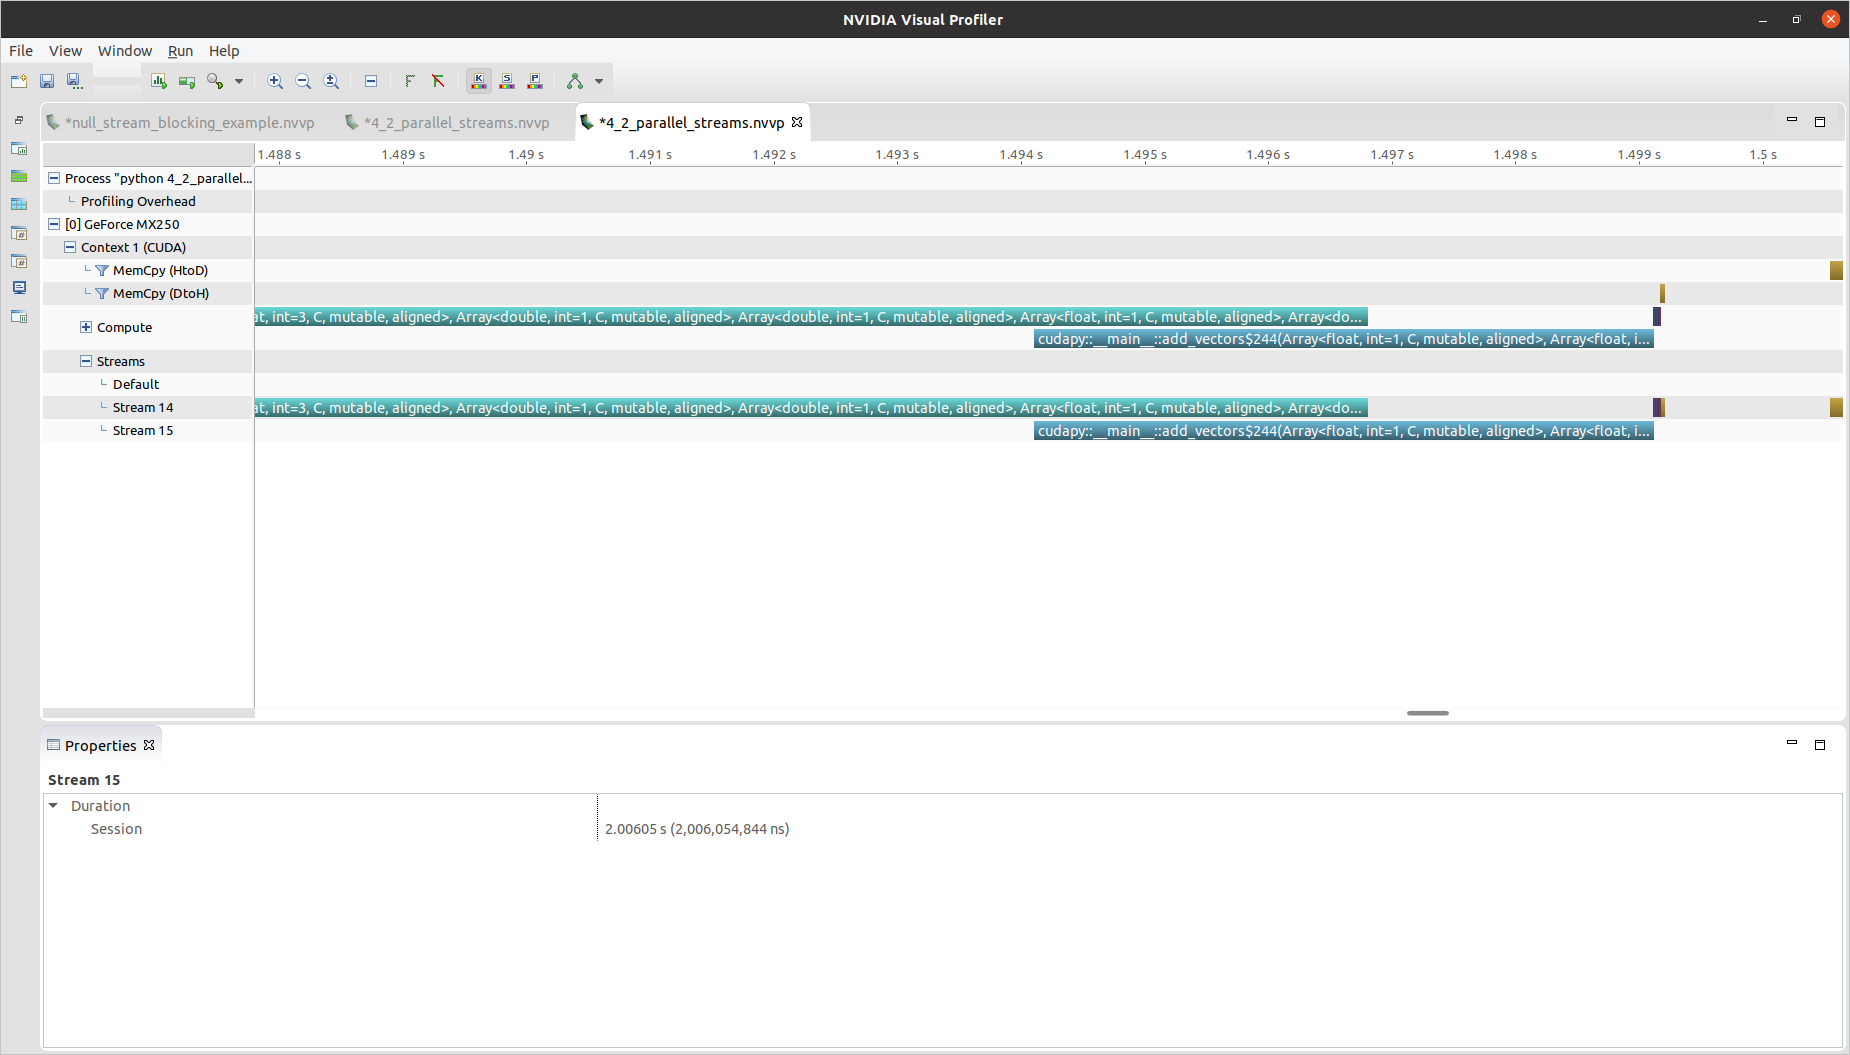

## 4.2.2. Overlapping data copy with processing.

One of the most common use cases for concurrent streams is to parallelize data transfer and data processing.

GPU cards have a separate data transfer (DMA) engines that can work in parallel with GPU streaming multiprocessors. Therefore it is possible to reduce the kernel execution time from:
 
 `transfer time + processing time` 
 
 to
 
 `max (transfer time, processing time) `

The script below demonstrates an attempt to parallelize data transfer and processing.

In [21]:
%%writefile 4_2_2_parallel_transfer_and_processing.py
import numpy as np
import cupy as cp
from numba import cuda
import math
from gpu_short_course.ultrasound_imaging import (
    # utility functions
    read_data,
    init_beamformer,
    create_grid,
    display_bmode,
    # GPU functions
    beamform,
    hilbert,
    to_bmode
)
rf, context = read_data("data/pwi_cyst_simulated.pkl")
context = init_beamformer(rf, context)

# Create streams
host_to_device_data_stream = cp.cuda.Stream(non_blocking=True)
processing_stream = cp.cuda.Stream(non_blocking=True)


input_buffer = [cp.zeros(rf.shape, dtype=cp.float32),
                cp.zeros(rf.shape, dtype=cp.float32)]
input_buffer_ready = [cp.cuda.Event(), cp.cuda.Event()]


for i in range(10): 
    rf_gpu = input_buffer[i%2]
    rf_gpu_ready = input_buffer_ready[i%2]

    # rf *= np.random.randn(*rf_gpu.shape).astype(np.float32)

    rf_gpu.set(rf, stream=host_to_device_data_stream)
    rf_gpu_ready.record(stream=host_to_device_data_stream)

    processing_stream.wait_event(rf_gpu_ready)
    hri        = beamform(rf_gpu, context, stream=processing_stream)
    envelope   = hilbert(hri, context, stream=processing_stream)
    # Do the rest of the job.
    bmode      = to_bmode(envelope, stream=processing_stream)
    # bmode_host = bmode.get(stream=processing_stream)

host_to_device_data_stream.synchronize()
processing_stream.synchronize()

Overwriting 4_2_2_parallel_transfer_and_processing.py


In [23]:
! nvprof --trace gpu --export-profile 4_2_2_parallel_transfer_and_processing.nvvp -f python 4_2_2_parallel_transfer_and_processing.py

==76312== NVPROF is profiling process 76312, command: python 4_2_2_parallel_transfer_and_processing.py
GPU:0: b'GeForce MX250'
==76312== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/4_2_2_parallel_transfer_and_processing.nvvp


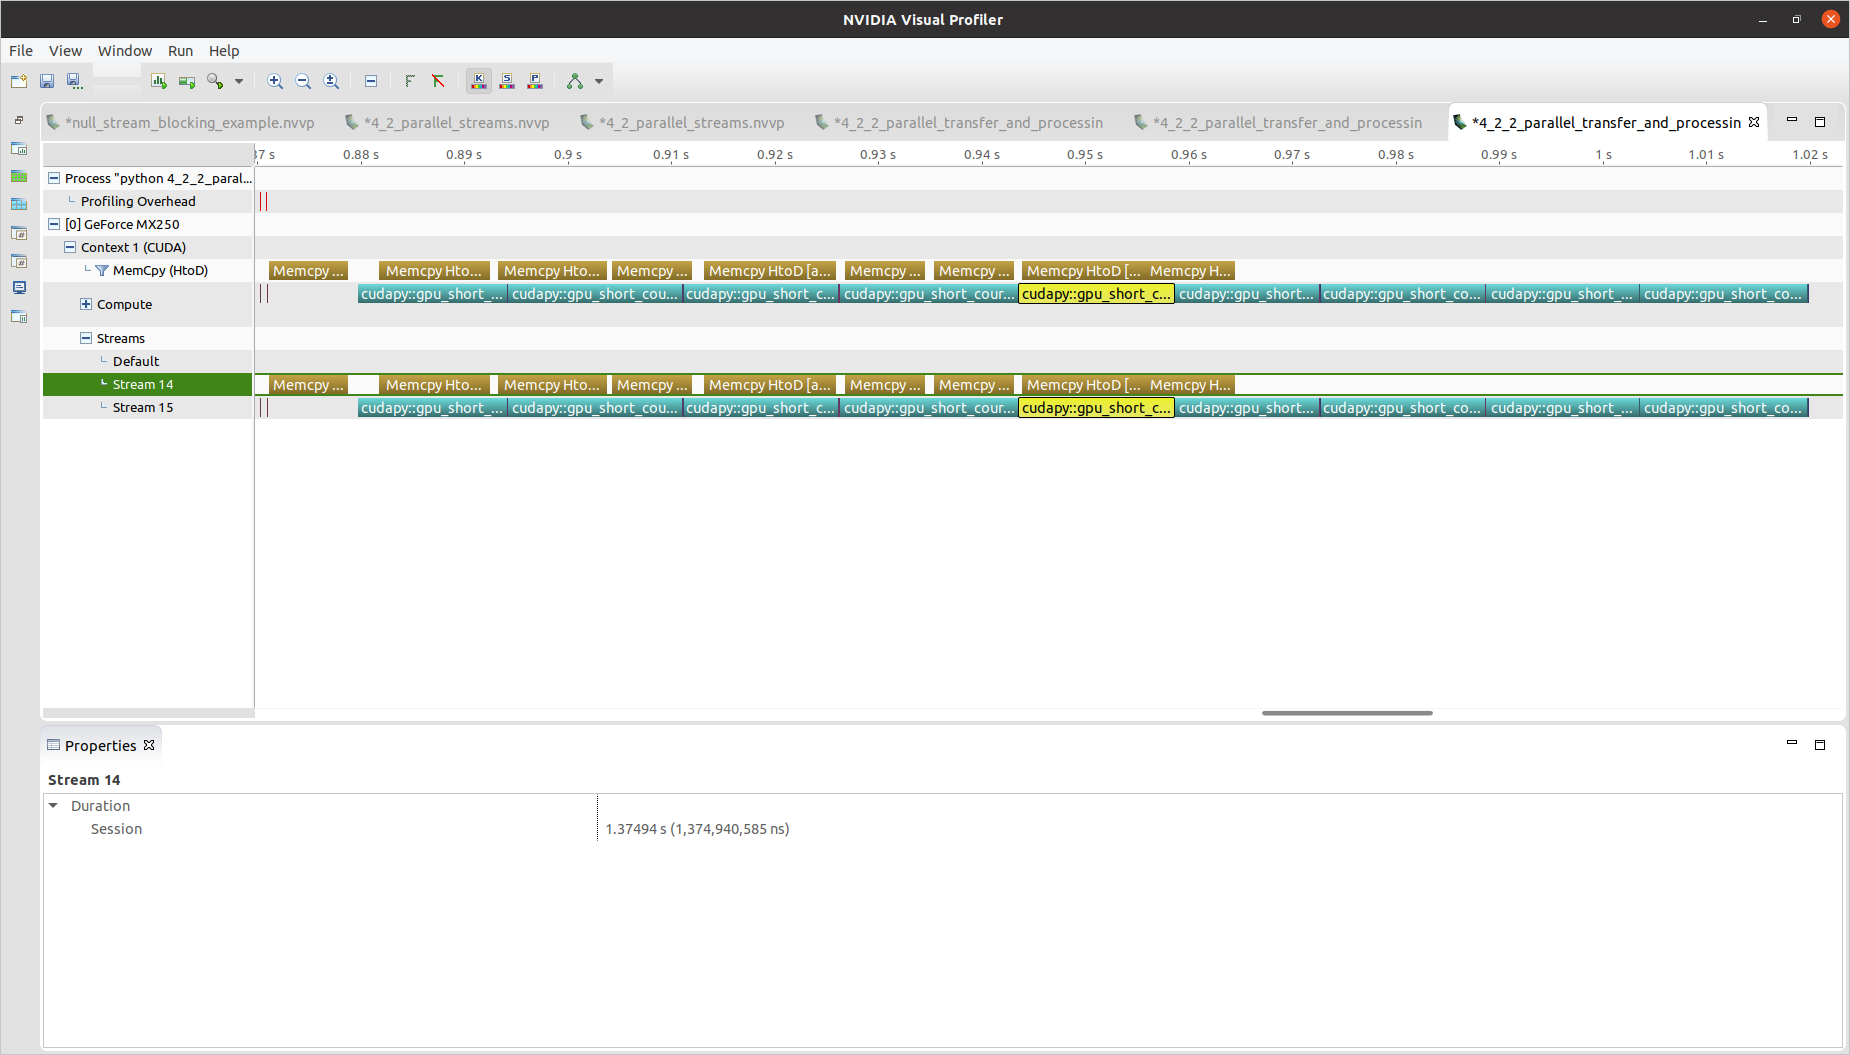

As we can see above, it was possible to get the data transfer and processing to be done in parallel. 

However, are you sure the above script works correctly? Is there anything wrong with the above graph?

Please notice, that the data is copied to GPU faster than it is processed. This means that the memcpy stream will overwrite eventually data that has not yet been processed.

For example, on the above screenshot you can see, that the fifth transfer (to the buffer 0) will start before the third processing completes (which actually uses the same input memory area, that is buffer 0).

This is a typical issue when the producer (GPU transfer stream in our case) produces the data faster than the consumer (our imaging stream) can process it. 

There are several solution to that problem:
- producer can wait until the consumer releases the given memory area,
- producer can raise an error when notice, that it is writing to still in use memory area (this can be use for time-critical applications),
- we can slow down the producer (e.g. artificially adding some delay),
- we can speed up the consumer (e.g. use a better GPU card, improve kernel performance, etc.), 
- ... and so on. 

Some of them will be described in greater detail in the future.

## 4.5. Pinned memory.

Will be described in the future. For now, take a look [here](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#pinned-memory).